MPDATA import

In [1]:
from MPyDATA.arakawa_c.scalar_field import ScalarField
from MPyDATA.arakawa_c.vector_field import VectorField
from MPyDATA.arakawa_c.boundary_condition.cyclic import Cyclic
import numpy as np
import matplotlib.pyplot as plt

Auxiliary functions import

           

In [2]:
from aux_one_dim import grad, extrapolate_in_time, interpolate_in_space

Advectee and advector initialization

In [3]:
from MPyDATA.options import Options
options = Options(n_iters=2, infinite_gauge=True, flux_corrected_transport=True)

nx = 5

initial_m_value = 0.2

# h_initial = np.full((1, nx), initial_m_value)
h_initial = np.full((nx), initial_m_value)
# h_initial[0][3] = 0.5
h_initial[3] = 0.5

h_old = np.array(h_initial)
h_new = np.array(h_initial)
uh_old = np.array(h_initial)
uh_new = np.array(h_initial)


# u_initial = np.zeros((1, nx + 1))
u_initial = np.zeros((nx + 1))

u_old = np.array(u_initial)
u_new = np.array(u_initial)

halo = options.n_halo

advectee = ScalarField(
    data = h_new,
    halo=halo, 
    boundary_conditions=(Cyclic(), )
)

advector = VectorField(
    data = (u_initial,),
    halo=halo,
    boundary_conditions=(Cyclic(), )   
)

print('h_new', h_new)
print()
print('u_new', u_new)

print()
print('grad', grad(h_new))

h_new [0.2 0.2 0.2 0.5 0.2]

u_new [0. 0. 0. 0. 0. 0.]

grad [ 0.    0.    0.15  0.   -0.3 ]


Stepper setup

In [4]:
from MPyDATA.stepper import Stepper
stepper = Stepper(options=options, grid=(1, nx))

from MPyDATA.solver import Solver
solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

Initial state

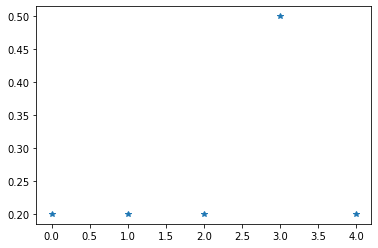

In [5]:
# plt.imshow(h_new, cmap='hot', interpolation='nearest')
plt.plot(h_new, '*')
plt.show()

Main loop

In [6]:
dt = 1.
rhs_old = np.array(h_old)
for _ in range(5):
 
    u_mid = extrapolate_in_time(interpolate_in_space(uh_new, h_new), interpolate_in_space(uh_old, h_old))

    
    print('u_mid', u_mid)
    #RHS = 0, mass conservation
#     solver.advectee = h_old
#     solver.advector = u_mid
    solver.advance(nt=1)
    h_new = solver.curr.get()
    print('h_new', h_new.shape)
    
    # -h * grad(h)
    rhs_new = - h_new * grad(h_new)
    
    #  momentum conservation
#     solver.advectee = h_old + 0.5 * dt * rhs_old
#     solver.advector = u_mid

    solver.advance(nt=1)
    h_new = solver.curr.get() + (.5* dt*rhs_new)
    
    
#     plt.imshow(h_new, cmap='hot', interpolation='nearest')
    plt.plot(h_new, '*')
    plt.show()
    
    #replace variables
    h_old = h_new
    u_old = u_new
    rhs_old = rhs_new

u_mid [0. 1. 1. 1. 1. 0.]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mInvalid use of Function(<built-in function setitem>) with argument(s) of type(s): (array(float64, 1d, C), UniTuple(int64 x 2), float64)
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 7:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 8:[0m
[1m    TypeError: cannot index array(float64, 1d, C) with 2 indices: UniTuple(int64 x 2)[0m
    raised from /home/white/study/cm/venv/lib/python3.6/site-packages/numba/core/typing/arraydecl.py:85
[1mIn definition 9:[0m
[1m    TypeError: cannot index array(float64, 1d, C) with 2 indices: UniTuple(int64 x 2)[0m
    raised from /home/white/study/cm/venv/lib/python3.6/site-packages/numba/core/typing/arraydecl.py:85
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of setitem at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/indexers.py (75)[0m
[1m
File "../../venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/indexers.py", line 75:[0m
[1mdef set_2d(arr, i, j, value):
[1m    arr[i, j] = value
[0m    [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[2] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (187)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[4] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (191)
[0m
[0m[1m[5] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[6] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (196)
[0m
[0m[1m[7] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[8] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (200)
[0m
[0m[1m[9] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[10] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (206)
[0m
[0m[1m[11] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[12] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (210)
[0m
[0m[1m[13] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[14] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (214)
[0m
[0m[1m[15] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[16] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (218)
[0m
[0m[1m[17] During: resolving callee type: type(CPUDispatcher(<function set_2d at 0x7fae66fe8bf8>))[0m
[0m[1m[18] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (187)
[0m
[1m
File "../../venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py", line 187:[0m
[1m        def boundary_cond_vector(meta, comp_0, comp_1, fun_0, fun_1):
            <source elided>
                    focus = (i, j)
[1m                    set(comp_0, i, j, fun_0((focus, comp_0), ni + 1, 1))
[0m                    [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function Traversals.make_boundary_conditions.<locals>.boundary_cond_vector at 0x7fae658d0510>))[0m
[0m[1m[2] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (107)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function Traversals.make_boundary_conditions.<locals>.boundary_cond_vector at 0x7fae658d0510>))[0m
[0m[1m[4] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py (107)
[0m
[1m
File "../../venv/lib/python3.6/site-packages/MPyDATA/arakawa_c/traversals.py", line 107:[0m
[1m        def apply_scalar(fun_0, fun_1,
            <source elided>
                         scal_arg4_meta, scal_arg_4, scal_arg4_bc0, scal_arg4_bc1):
[1m            boundary_cond_vector(vec_arg1_meta, vec_arg1_0, vec_arg1_1, vec_arg1_bc0, vec_arg1_bc1)
[0m            [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function Traversals.make_apply_scalar.<locals>.apply_scalar at 0x7fae658d08c8>))[0m
[0m[1m[2] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/formulae/flux_corrected_transport.py (27)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function Traversals.make_apply_scalar.<locals>.apply_scalar at 0x7fae658d08c8>))[0m
[0m[1m[4] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/formulae/flux_corrected_transport.py (27)
[0m
[1m
File "../../venv/lib/python3.6/site-packages/MPyDATA/formulae/flux_corrected_transport.py", line 27:[0m
[1m        def apply(psi_extremum, psi, psi_bc, null_vecfield, null_vecfield_bc):
            <source elided>
            return apply_scalar(*formulae, *psi_extremum, *null_vecfield, *null_vecfield_bc, *psi, *psi_bc,
[1m                                *null_scalfield, *null_scalfield_bc, *null_scalfield, *null_scalfield_bc)
[0m                                [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function make_psi_extremum.<locals>.apply at 0x7fae658f6378>))[0m
[0m[1m[2] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/stepper.py (115)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function make_psi_extremum.<locals>.apply at 0x7fae658f6378>))[0m
[0m[1m[4] During: typing of call at /home/white/study/cm/venv/lib/python3.6/site-packages/MPyDATA/stepper.py (115)
[0m
[1m
File "../../venv/lib/python3.6/site-packages/MPyDATA/stepper.py", line 115:[0m
[1m    def step(nt, mu_coeff,
        <source elided>
                    if flux_corrected_transport:
[1m                        fct_psi_min(psi_min, psi, psi_bc, null_vecfield, null_vecfield_bc)
[0m                        [1m^[0m[0m
